<a href="https://colab.research.google.com/github/doananh020418/car-lisence-plate/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from importlib.machinery import SourceFileLoader
from os.path import join
somemodule = SourceFileLoader('local_utils',  '/content/drive/My Drive/Plate detection/local_utils.py').load_module()

In [ ]:
import cv2
import imutils
import numpy as np
from os.path import splitext
from local_utils import detect_lp
from keras.models import model_from_json
from google.colab.patches import cv2_imshow
import matplotlib.gridspec as gridspec


In [ ]:
#Hàm key lúc sort
def takeFirst(elem):
    return elem[0]

In [ ]:
#Load WPOD để detect vùng biển
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [ ]:
#tiền xử lý ảnh
def pre_process_img(img):
    resize=False
    # đưa ảnh về thang màu RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # chuẩn hóa các pixel về dải 0-1
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

Found 22 images...


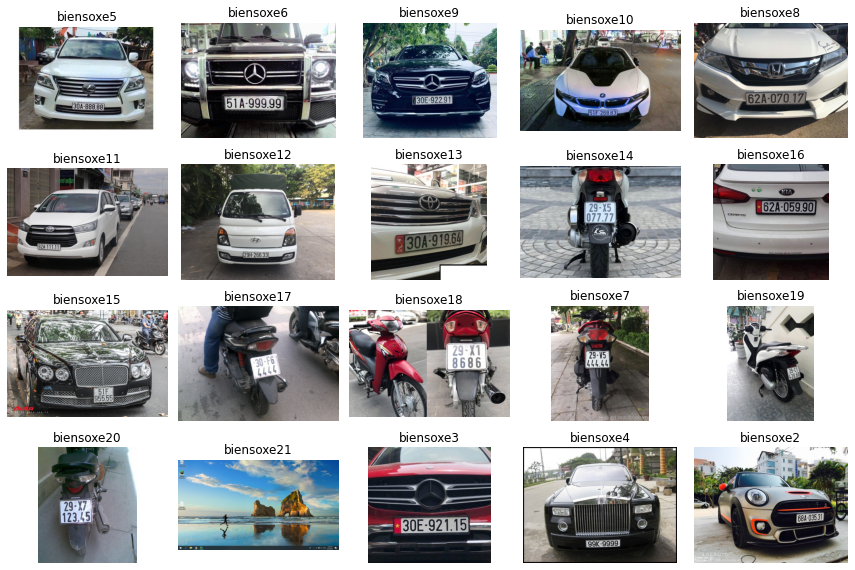

In [ ]:
import glob
import matplotlib.pyplot as plt
from os.path import splitext, basename
image_paths = glob.glob("/content/drive/MyDrive/Plate detection/Examples/*.png")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 4
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = pre_process_img(cv2.imread(image_paths[i]))
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

In [ ]:
#lấy ra vùng ảnh chứa biển số
def get_plate(img):
    Dmax = 600
    Dmin = 256
    try:
        img_pre_process = pre_process_img(img)
        check = float(max(img_pre_process.shape[:2])) / min(img_pre_process.shape[:2])
        side = int(check * Dmin)
        bound_dim = min(side, Dmax)

        # tìm ra vùng ảnh chứ biển số
        _, place_img, _, cor = detect_lp(wpod_net, img_pre_process, bound_dim, lp_threshold=0.5)
    except:
        place_img = None
        cor = None
    return place_img, cor

Coordinate of plate(s) in image: 
 None


TypeError: ignored

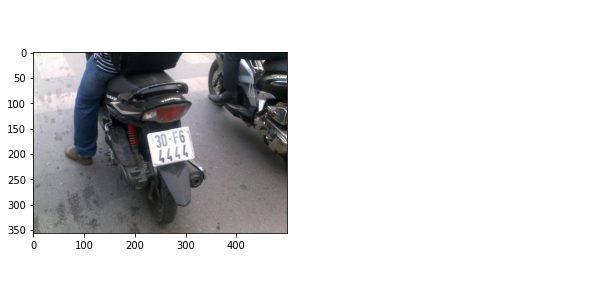

In [ ]:
test_image = image_paths[11]
LpImg,cor = get_plate(cv2.imread(test_image))
#print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(True)
plt.imshow(pre_process_img(cv2.imread(test_image)))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

In [ ]:
#xử lý ảnh
def process_img(place_img):

    # kiểm tra có ảnh vùng biển
    if (len(place_img)):

        # chuyển đổi đưa ảnh về hệ 8bit
        plate_img = cv2.convertScaleAbs(place_img[0], alpha=(255.0))
        
        
        # chuyển ảnh sang thang xám và làm mở
        img_gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
        
        img_blur = cv2.GaussianBlur(img_gray, (7, 7), 0)
      
        


        # Phân ngưỡng ảnh
        binary = cv2.threshold(img_blur, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        
          

        #dãn nở nhằm khử nhiễu và đưa ra ảnh đã được xử lý
        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        img_thre = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
        
        cv2_imshow(plate_img)      
                
        cv2_imshow(img_gray)

        cv2_imshow(img_blur)

        cv2_imshow(binary)

        cv2_imshow(img_thre)
        
        
    return img_thre

In [ ]:
#tìm ra đường viền bao
def find_contours(img_thre):
    point = []

    #tìm ra các đường viền trong ảnh
    contours = cv2.findContours(img_thre.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    #contours = sorted(contours, key = cv2.contourArea, reverse = True)[:7]

    #duyệt qua các đường bao
    for c in contours:
        #tính chu vi, tìm ra hình vuông xấp xỉ bao quanh và đưa ra tọa độ, dài, rộng
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * peri, True)
        x, y, w, h = cv2.boundingRect(approx)

        #kiểm ra các ô vuông, chỉ ra các ô chứa ký tự
        if 17 <= w <= 55 and 63 <= h <= 86:
            point.append((x, y, w, h))
    return point

In [ ]:
#sắp xếp lại các ký tự đúng theo thứ tự biển số
def sort_point(img_thre, point):
    point1 = []
    point2 = []
    rate = img_thre.shape[1] / img_thre.shape[0]

    #biển chữ nhật
    if rate > 3:
        point.sort(key = takeFirst)

    #biển vuông
    else:
        mean = np.mean(np.array(point), axis= 0)[1]
        for x in point:
            if x[1] < mean:
                point1.append(x)
            else:
                point2.append(x)
        point1.sort(key=takeFirst)
        point2.sort(key=takeFirst)
        point = point1 + point2
    return point

In [ ]:
#tách các ký tự ra làm từng ảnh con và đưa về dạng 30*60 rồi chuyển về dạng thích hơp làm input cho model
def find_char(point,img_thre):
    character = []
    point = sort_point(img_thre,point)
    for i in point:

        # vẽ ô vuông quanh các ký tự
        x,y,w,h = i
        cv2.rectangle(place_img[0],(x,y),(x+w,y+h),(0, 255,0), 2)

        #bóc các ký tự về ảnh con
        pts1 = np.float32([[x,y],[x+w,y],[x,y+h],[x+w,y+h]])
        pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
        matrix = cv2.getPerspectiveTransform(pts1,pts2)
        char = cv2.warpPerspective(img_thre, matrix, (w,h))

        #đưa về dạng thích hợp để làm input cho model
        char = cv2.resize(char,(30,60))
        char = char.reshape(-1, 30 * 60)
        character.append(char)
    character = np.array(character, dtype=np.float32)

    fig = plt.figure(figsize=(10,6))
    plt.axis(False)
    plt.imshow(place_img[0])

    fig = plt.figure(figsize=(14,4))
    grid = gridspec.GridSpec(ncols=len(character),nrows=1,figure=fig)
    for i in range(len(character)):
      fig.add_subplot(grid[i])
      plt.axis(False)
      plt.imshow(character[i])
      plt.show()
        

    return character

In [ ]:
def recognize(model_svm,character):
    string = ''
    
    #dự đoán các ký tự
    for i in range(character.shape[0]):
        result = model_svm.predict(character[i])

        result = int(result[1][0][0])

        #chuyển lại mã ascii về ký tự
        result = chr(result)

        string += result
    return string

In [ ]:
#format lại string vừa nhận diện
def format(string):
    string_new = ''
    if len(string) == 7:
        for i in range(len(string)):
            if i == 3:
                string_new += '-'
            string_new += string[i]
    elif len(string) == 8:
        for i in range(len(string)):
            if i == 3:
                string_new += '-'
            elif i == 6:
                string_new += '.'
            string_new += string[i]
    elif len(string) == 9:
        for i in range(len(string)):
            if i == 2:
                string_new += '-'
            elif i == 4:
                string_new += ' '
            elif i == 7:
                string_new += '.'
            string_new += string[i]

    return string_new


In [ ]:
#viết biển số lên ảnh
def draw_box(img, cor, string):
    pts = []

    #tọa x của 4 góc biển số
    x = cor[0][0]

    # tọa y của 4 góc biển số
    y= cor[0][1]

    for i in range(4):
        pts.append([int(x[i]), int(y[i])])
    pts = np.array(pts)
    peri = cv2.arcLength(pts, True)
    approx = cv2.approxPolyDP(pts, 0.018 * peri, True)
    x, y, w, h = cv2.boundingRect(approx)

    #vẽ ô vuông và biển số lên ảnh
    cv2.putText(img, string, (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN, 1.5,255, 2)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255,0), 2)

In [ ]:
wpod_net = load_model("/content/drive/My Drive/Plate detection/wpod-net.json")

model_svm = cv2.ml.SVM_load('/content/drive/My Drive/Plate detection/model_svm.xml')

import time
t = time.time()
for i in range(0,1):
    img_path = r"/content/drive/MyDrive/Plate detection/Examples/biensoxe{}.png".format(i)

    img = cv2.imread(img_path)

    place_img,cor = get_plate(img)
    if place_img != None and cor != None:
      img_thre = process_img(place_img)

      cv2_imshow(place_img[0])

      point = find_contours(img_thre)

      character = find_char(point, img_thre)

      string = recognize(model_svm,character)

      string_speak = string

      string = format(string)

      draw_box(img, cor, string)

      print(string)

    

    cv2_imshow( img)
  
    #cv2.imwrite(r'/content/drive/My Drive/Plate detection/Examples/Ibiensoxe{}.jpeg'.format(i), img)
    cv2.waitKey(1)
